In [0]:
%matplotlib inline

In [0]:
# License: BSD
# Author: Sasank Chilamkurthy
# Used as reference for Jetson Nano Hackathon
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.nn.functional as F # added this import

plt.ion()   # interactive mode

In [3]:
from google.colab import drive 
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install unrar

In [0]:
!python colabtools-master/setup.py build

python3: can't open file 'colabtools-master/setup.py': [Errno 2] No such file or directory


In [0]:
import zipfile
path_to_zip_file = '/content/gdrive/My Drive/PyTorch/avengers-dc-data/dataset-pytorch/val/captain-america/captain-val.zip'
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall('/content/gdrive/My Drive/PyTorch/avengers-dc-data/dataset-pytorch/val/captain-america/')

In [0]:
cd 'gdrive/My Drive/PyTorch/avengers-dc-data/dataset-pytorch/val/captain-america/captain-val/'

/content/gdrive/My Drive/PyTorch/avengers-dc-data/dataset-pytorch/val/captain-america/captain-val


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [0]:
cp * ../

In [0]:
!pwd

/content


Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/My Drive/PyTorch/avengers-dc-data/dataset-pytorch'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=16)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
print(class_names)

['antman', 'batman', 'captain-america', 'hulk', 'ironman', 'reverse-flash', 'spiderman', 'thor']


Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



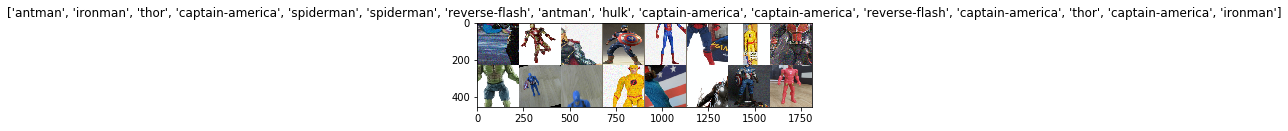

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    outputs = F.log_softmax(outputs, dim=1) # added this line
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            # To get probability tensor
            sm = torch.nn.Softmax()
            prob = sm(outputs)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                print("Probability: " + str(torch.max(prob[j])))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [0]:
!wget https://download.pytorch.org/models/resnet18-5c106cde.pth --no-check-certificate
!mv resnet18-5c106cde.pth /root/.cache/torch/checkpoints/

In [0]:
model_ft = models.resnet18(pretrained=True)
# model_ft.fc = nn.Linear(512,8)
# num_ftrs = model_ft.fc.in_features
# model_ft.fc[index] = nn.Linear(512,8)
model_ft.fc = nn.Sequential(nn.Linear(512, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 8),
                                 nn.LogSoftmax(dim=1))
model_ft = model_ft.to(device)

criterion = nn.NLLLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [0]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=16)

Epoch 0/15
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 1.9734 Acc: 0.2581
val Loss: 1.8801 Acc: 0.4336

Epoch 1/15
----------
train Loss: 1.6279 Acc: 0.5935
val Loss: 1.5955 Acc: 0.6070

Epoch 2/15
----------
train Loss: 1.2851 Acc: 0.7226
val Loss: 1.2130 Acc: 0.6125

Epoch 3/15
----------
train Loss: 0.9748 Acc: 0.7935
val Loss: 0.8035 Acc: 0.7913

Epoch 4/15
----------
train Loss: 0.7127 Acc: 0.8290
val Loss: 0.5782 Acc: 0.9350

Epoch 5/15
----------
train Loss: 0.4926 Acc: 0.8935
val Loss: 0.5079 Acc: 0.9241

Epoch 6/15
----------
train Loss: 0.4311 Acc: 0.9065
val Loss: 0.4861 Acc: 0.9268

Epoch 7/15
----------
train Loss: 0.4044 Acc: 0.9419
val Loss: 0.4604 Acc: 0.9268

Epoch 8/15
----------
train Loss: 0.4319 Acc: 0.8935
val Loss: 0.4338 Acc: 0.9377

Epoch 9/15
----------
train Loss: 0.4159 Acc: 0.9258
val Loss: 0.4354 Acc: 0.9322

Epoch 10/15
----------
train Loss: 0.4353 Acc: 0.9226
val Loss: 0.4215 Acc: 0.9350

Epoch 11/15
----------
train Loss: 0.3951 Acc: 0.9226
val Loss: 0.4229 Acc: 0.9350

Epoch 12/15
----------
t

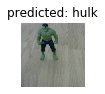

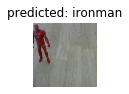

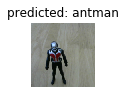

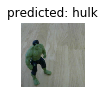

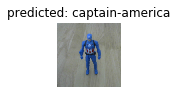

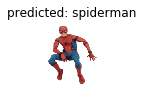

In [0]:
visualize_model(model_ft)

In [0]:
!mkdir "/content/drive/My Drive/avengers_models"

In [0]:
torch.save(model_ft.state_dict(), '/content/drive/My Drive/avengers_models/resnet18_log_softmax.pth')
# torch.save(model_ft.state_dict(), '/content/gdrive/My Drive/PyTorch/Model/model_resnet18_ft_new_data.pth')

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [0]:
model_conv = models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 8)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [0]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.6209 Acc: 0.8293
val Loss: 0.1500 Acc: 0.9648

Epoch 1/9
----------
train Loss: 0.3372 Acc: 0.9011
val Loss: 0.1091 Acc: 0.9725

Epoch 2/9
----------
train Loss: 0.2930 Acc: 0.9101
val Loss: 0.0892 Acc: 0.9791

Epoch 3/9
----------
train Loss: 0.2757 Acc: 0.9118
val Loss: 0.0772 Acc: 0.9778

Epoch 4/9
----------
train Loss: 0.2609 Acc: 0.9159
val Loss: 0.0677 Acc: 0.9871

Epoch 5/9
----------
train Loss: 0.2486 Acc: 0.9199
val Loss: 0.0637 Acc: 0.9874

Epoch 6/9
----------
train Loss: 0.2423 Acc: 0.9211
val Loss: 0.0641 Acc: 0.9857

Epoch 7/9
----------
train Loss: 0.2354 Acc: 0.9256
val Loss: 0.0645 Acc: 0.9834

Epoch 8/9
----------
train Loss: 0.2347 Acc: 0.9251
val Loss: 0.0660 Acc: 0.9851

Epoch 9/9
----------
train Loss: 0.2293 Acc: 0.9269
val Loss: 0.0654 Acc: 0.9841

Training complete in 37m 51s
Best val Acc: 0.987396


In [0]:
torch.save(model_conv.state_dict(), '/content/gdrive/My Drive/PyTorch/Model/model_resnet18_new_data_2.pth')

# Using MNASNET

In [0]:
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
for param in vgg16.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
# num_ftrs = model_conv.fc.in_features
"""model_incept.fc = nn.Sequential(nn.Linear(512, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 8),
                                 nn.LogSoftmax(dim=1))"""


num_ftrs = vgg16.fc.in_features
vgg16.fc = nn.Linear(num_ftrs, 8)                                

vgg16 = vgg16.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(vgg16.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [0]:
vgg16 = train_model(vgg16, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

# Save/Load Model

In [0]:
# Save the model: resnet18
torch.save({'epoch': '10',
            'model_state_dict': model_ft.state_dict(),
            'optimizer_state_dict': optimizer_conv.state_dict(),
            'loss': '0.2031'},'/content/gdrive/My Drive/PyTorch/Model/model_ft_resnet18_2.model')

In [0]:
model = models.resnet18()
checkpoint = torch.load('/content/gdrive/My Drive/PyTorch/Model/model_ft_resnet18_2.model')
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
print(model.eval())

In [0]:
model = torch.load('/content/gdrive/My Drive/PyTorch/Model/model_ft_resnet18.model')
print(model)

# Visualize Model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


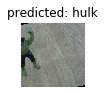

Probability: tensor(0.9973, device='cuda:0')


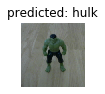

Probability: tensor(0.9982, device='cuda:0')


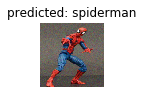

Probability: tensor(0.9996, device='cuda:0')


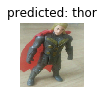

Probability: tensor(0.9977, device='cuda:0')


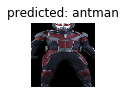

Probability: tensor(0.9928, device='cuda:0')


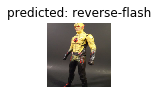

Probability: tensor(0.8874, device='cuda:0')


In [0]:
visualize_model(model_conv)

plt.ioff()
plt.show()